In [ ]:
# https://medium.com/geekculture/pytorch-training-fruit-360-classifier-under-5-mins-23153b46ec88

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/moltean/fruits'
# kaggleのusernameとkeyを入力します
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


IMAGE_SIZE = 48

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMAGE_SIZE),
])

data_dir = '/content/fruits/fruits-360_dataset/fruits-360/'
train_dataset = ImageFolder(data_dir + "Training", transform=transform)
test_dataset = ImageFolder(data_dir + "Test", transform=transform)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)

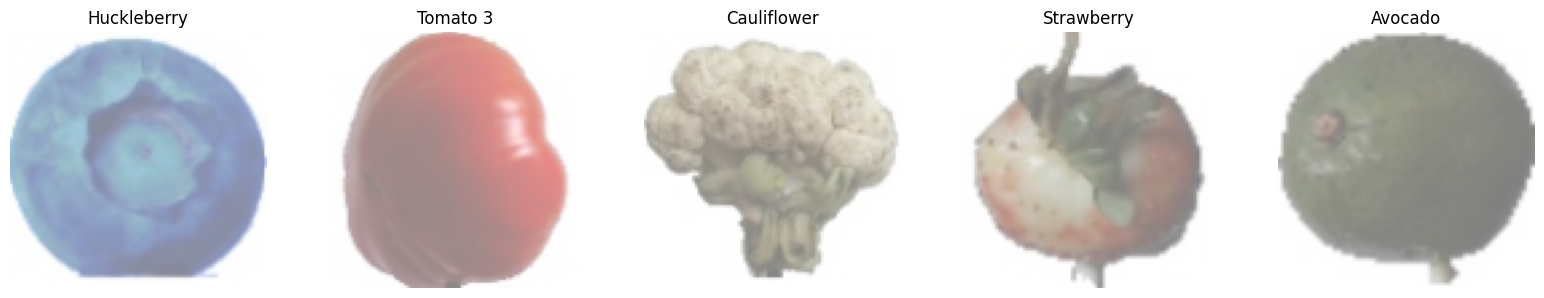

In [ ]:
def show_samples():
    num_images = 5
    imgs = next(iter(train_loader))[:num_images]

    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])

    fig = plt.figure(figsize=(16, 3))

    for i in range(num_images):
        ax = fig.add_subplot(1, num_images, i+1)

        img = imgs[0][i].permute(1, 2, 0)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.classes[imgs[1][i]])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_samples()

# **VAE**
第3回演習を参考

In [ ]:
def torch_log(x: torch.Tensor) -> torch.Tensor:
    return torch.log(torch.clamp(x, min=1e-10))

# VAEモデル（別の構成）
class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        # Encoder
        self.enc = nn.Sequential(
            nn.Linear(3*48*48, 1024),
            nn.BatchNorm1d(1024)
        )
        self.enc_mean = nn.Linear(1024, z_dim)
        self.enc_std = nn.Linear(1024, z_dim)

        # Decoder
        self.dec_lin = nn.Linear(z_dim, 1024)
        self.dec = nn.Sequential(
            nn.Linear(1024, 3*48*48),
            nn.Sigmoid(),
        )

    def encoder(self, x):
        h = self.enc(x)

        mean = self.enc_mean(h)
        std = F.softplus(self.enc_std(h))

        return mean, std

    def decoder(self, z):
        h = self.dec_lin(z)
        x = self.dec(h)
        return x

    def sample_z(self, mean: torch.Tensor, std: torch.Tensor):
        """
        訓練時に再パラメータ化トリックによってガウス分布から潜在変数をサンプリングする．
        推論時はガウス分布の平均を返す
        mean: ガウス分布の平均 (b, z_dim)
        std: ガウス分布の標準偏差 (b, z_dim)
        """
        if self.training:
            epsilon = torch.randn(mean.shape).to(device)
            return mean + std * epsilon
        else:
            return mean

    def loss(self, x: torch.Tensor):
        mean, std = self.encoder(x)

        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))

        z = self.sample_z(mean, std)
        y = self.decoder(z)

        reconstruction_loss = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))

        return KL, -reconstruction_loss, y.view(x.size(0), 3, 48, 48)

In [ ]:
def plot_reconst(reconstruction):

    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])

    num_images = len(reconstruction)
    fig = plt.figure(figsize=(16, 3))
    for i in range(num_images):
        ax = fig.add_subplot(1, num_images, i+1)

        # 画像の正規化
        img = reconstruction[i].cpu().permute(1, 2, 0)
        img = torch.clamp(img, 0, 1)

        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

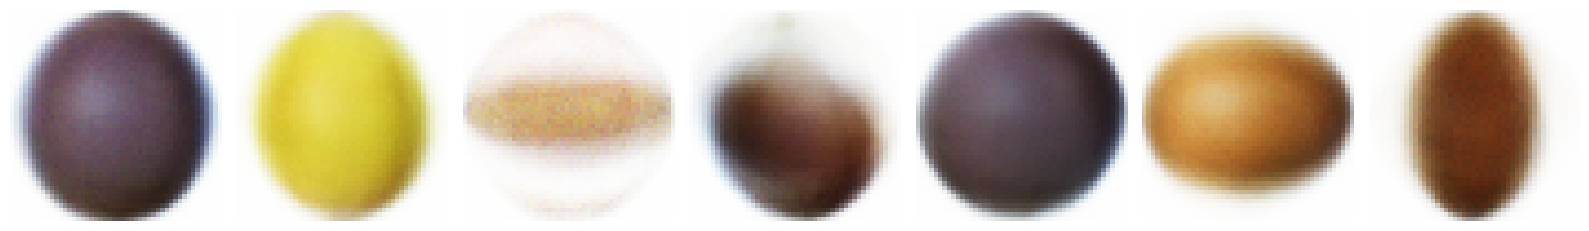

EPOCH: 1    Lower Bound: 3148.218506 (KL_loss: 152.758133. reconstruction_loss: 2995.460693)


In [ ]:
z_dim = 128 # >= 2
model = VAE(z_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

n_epochs = 35
for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []

    model.train()
    for x, _ in train_loader:
        x = x.view(x.size(0), -1)
        x = x.to(device)
        model.zero_grad()

        KL_loss, reconstruction_loss, reconstruction = model.loss(x)

        loss = KL_loss + reconstruction_loss

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    model.eval()
    with torch.no_grad():
        num_images = 7
        x = next(iter(test_loader))[0][:num_images]
        x = x.view(x.size(0), -1)
        x = x.to(device)
        _, _, reconstruction = model.loss(x)
        plot_reconst(reconstruction)

    print('EPOCH: %d    Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))